In [1]:
import numpy as np
import matplotlib.pyplot as plt
from  mpl_toolkits.axisartist.grid_helper_curvelinear import GridHelperCurveLinear
from mpl_toolkits.axisartist import Subplot

In [2]:
import time

import IPython.display as IPd
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import torch

import stg_energy.fig4_sensitivity.viz as viz
from pyloric import get_time, simulate_energyscape, stats
from sbi.utils.regression_net.get_nn_classifier import classifier
from sbi.utils.regression_net.train_classifier import fit_regression_net
from stg_energy.common import svg
from stg_energy.fig3_amortize_energy.helper_functions import active_subspace
from stg_energy.fig3_amortize_energy.viz import (
    energy_scape,
    plot_eigenvalues,
    py_sensitivity_bars,
)
from stg_energy.fig4_sensitivity.helper_functions import (
    nth_argmax,
    nth_argmin,
    prepare_data,
    regression_plot,
)

# Figure 4

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
PANEL_supp1 = "../svg/panel_supp1.svg"
PANEL_supp2 = "../svg/panel_supp2.svg"

PANEL_A0_NEW = "../svg/panel_a0_new.svg"
PANEL_A1_NEW = "../svg/panel_a1_new.svg"
PANEL_A2_NEW = "../svg/panel_a2_new.svg"
PANEL_B0_NEW = "../svg/panel_b0_new.svg"
PANEL_B1_NEW = "../svg/panel_b1_new.svg"
PANEL_B2_NEW = "../svg/panel_b2_new.svg"
PANEL_C_NEW = "../svg/panel_c_new.svg"
PANEL_D1_NEW = "../svg/panel_d1_new.svg"
PANEL_D2_NEW = "../svg/panel_d2_new.svg"
PANEL_D3_NEW = "../svg/panel_d3_new.svg"
PANEL_D4_NEW = "../svg/panel_d4_new.svg"
PANEL_D5_NEW = "../svg/panel_d5_new.svg"
PANEL_D6_NEW = "../svg/panel_d6_new.svg"

### Sort out the data from the cluster

In [5]:
outfile = "../../results/11deg_post_pred/11_deg_post_pred_close_to_obs.npz"
data_n = np.load(outfile)
sample_seeds = data_n["sample_seeds"]
sample_params = data_n["sample_params"]
sample_stats = data_n["sample_stats"]
print("There are", len(sample_seeds), "datapoints in this dataset")

There are 55043 datapoints in this dataset


# Train regression net

### Prepare parameters

In [6]:
num_test = 500

test_params = sample_params[:num_test]
train_params = sample_params[num_test:]
mean_params = np.mean(train_params, axis=0)
std_params = np.std(train_params, axis=0)

train_params_norm = (train_params - mean_params) / std_params
test_params_norm = (test_params - mean_params) / std_params

### Prepare energy/spike

In [7]:
all_energies_per_spike_ABPD = sample_stats[:, 18]

In [8]:
numSpikesPerBurst = sample_stats[:, -6] / sample_stats[:, -3]

In [9]:
(
    mean_energies_per_spike,
    std_energies_per_spike,
    train_energies_per_spike_norm,
    test_energies_per_spike_norm,
    mean_num_spikes,
    std_num_spikes,
    train_num_spikes_norm,
    test_num_spikes_norm,
) = prepare_data(all_energies_per_spike_ABPD, numSpikesPerBurst, num_test)

In [10]:
unnorm_x_vals, unnorm_y_regs, unnorm_x, unnorm_y = regression_plot(
    mean_energies_per_spike,
    std_energies_per_spike,
    train_energies_per_spike_norm,
    test_energies_per_spike_norm,
    mean_num_spikes,
    std_num_spikes,
    train_num_spikes_norm,
    test_num_spikes_norm,
)

### Train classifier for energy per spike

In [11]:
nn = classifier(dim=31)

In [12]:
# converged_nn = fit_regression_net(
#     nn,
#     train_params_norm,
#     train_energies_per_spike_norm,
#     num_train=train_params_norm.shape[0],
#     batch_size=50,
#     stop_after_epochs=10,
#     max_epochs=200
# )

In [13]:
# np.savez('../../results/regression_nets/200821_predict_energyPerSpike_ABPD.npz', converged_nn=converged_nn)

In [14]:
data = np.load(
    "../../results/regression_nets/200821_predict_energyPerSpike_ABPD.npz",
    allow_pickle=True,
)
converged_nn = data["converged_nn"].tolist()

In [15]:
predictions = converged_nn.predict(torch.as_tensor(test_params_norm)).detach().numpy()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


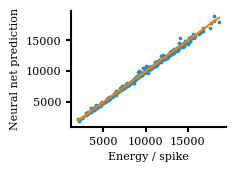

In [16]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.5))
    unnorm_x = (
        test_energies_per_spike_norm[:300] * std_energies_per_spike
        + mean_energies_per_spike
    )
    unnorm_y = predictions[:300] * std_energies_per_spike + mean_energies_per_spike
    ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x), np.max(unnorm_x), 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Energy / spike")
    ax.set_ylabel("Neural net prediction")
    plt.savefig(PANEL_supp1, facecolor="None", transparent=True)

### Regression network for #spikes

In [17]:
nn = classifier(dim=31)

In [18]:
# converged_nn_num_spikes = fit_regression_net(
#     nn,
#     train_params_norm,
#     train_num_spikes_norm,
#     num_train=train_params_norm.shape[0],
#     batch_size=50,
#     stop_after_epochs=10,
#     max_epochs=200
# )

In [19]:
# np.savez('../../results/regression_nets/200821_predict_numSpikes_ABPD.npz', converged_nn=converged_nn_num_spikes)

In [20]:
data = np.load(
    "../../results/regression_nets/200821_predict_numSpikes_ABPD.npz", allow_pickle=True
)
converged_nn_num_spikes = data["converged_nn"].tolist()

In [21]:
predictions = (
    converged_nn_num_spikes.predict(torch.as_tensor(test_params_norm)).detach().numpy()
)

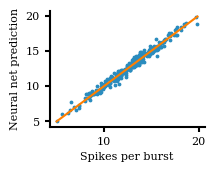

In [22]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.5))
    unnorm_x = test_num_spikes_norm[:300] * std_num_spikes + mean_num_spikes
    unnorm_y = predictions[:300] * std_num_spikes + mean_num_spikes
    ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x), np.max(unnorm_x), 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Spikes per burst")
    ax.set_ylabel("Neural net prediction")
    plt.savefig(PANEL_supp2, facecolor="None", transparent=True)

### Get active subspace for E / spike

In [23]:
e_vals_e_per_spike, e_vecs_e_per_spike = active_subspace(converged_nn, test_params_norm)

Ratio of first to second eigenvalue:  tensor(7.5753)


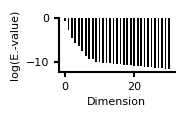

In [24]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    plot_eigenvalues(
        torch.log(torch.flip(e_vals_e_per_spike, dims=(0,))),
        figsize=(1.5, 0.7),
        ylabel="log(E.-value)",
        color='k'
    )
    print(
        "Ratio of first to second eigenvalue: ",
        e_vals_e_per_spike[-1] / e_vals_e_per_spike[-2],
    )
    plt.savefig(PANEL_A0_NEW, facecolor="None", transparent=True)
    plt.show()

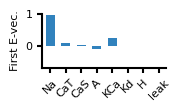

In [25]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    py_sensitivity_bars(
        e_vecs_e_per_spike[0:8, -1:].T,
        ylim=[-0.7, 1.0],
        figsize=(1.6, 0.7),
        ylabel="First E-vec.",
        plot_labels=True,
        color="#3182bd",
    )
    plt.savefig(PANEL_A1_NEW, facecolor="None", transparent=True)
    plt.show()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


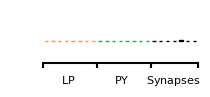

In [26]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.other_sensitivity_bars(
        e_vecs_e_per_spike[8:, -1:].T, ylim=[-0.7, 1.0], figsize=(2.0, 0.7)
    )
    plt.savefig(PANEL_A2_NEW, facecolor="None", transparent=True)
    plt.show()

### Get active subspace for number of spikes

In [27]:
e_vals_numSpikes, e_vecs_numSpikes = active_subspace(
    converged_nn_num_spikes, test_params_norm
)

Ratio of first to second eigenvalue:  tensor(15.8987)


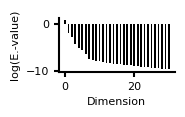

In [28]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    plot_eigenvalues(
        torch.log(torch.flip(e_vals_numSpikes, dims=(0,))),
        figsize=(1.5, 0.7),
        ylabel="log(E.-value)",
        color='k'
    )
    print(
        "Ratio of first to second eigenvalue: ",
        e_vals_numSpikes[-1] / e_vals_numSpikes[-2],
    )
    plt.savefig(PANEL_B0_NEW, facecolor="None", transparent=True)
    plt.show()

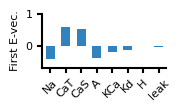

In [29]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    py_sensitivity_bars(
        e_vecs_numSpikes[0:8, -1:].T,
        ylim=[-0.7, 1.0],
        figsize=(1.6, 0.7),
        ylabel="First E-vec.",
        plot_labels=True,
        color="#3182bd",
    )
    plt.savefig(PANEL_B1_NEW, facecolor="None", transparent=True)
    plt.show()

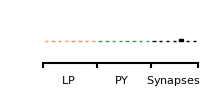

In [30]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.other_sensitivity_bars(
        e_vecs_numSpikes[8:, -1:].T, ylim=[-0.7, 1.0], figsize=(2.0, 0.7)
    )
    plt.savefig(PANEL_B2_NEW, facecolor="None", transparent=True)
    plt.show()

In [31]:
v1 = e_vecs_numSpikes[:, -1]
v2 = e_vecs_e_per_spike[:, -1]

In [32]:
norm_v1 = torch.norm(v1)
print(v2)

tensor([ 9.6191e-01,  9.2882e-02,  3.0062e-02, -1.1427e-01,  2.2704e-01,
        -8.6922e-03, -6.3886e-05, -8.1381e-03, -4.9925e-04,  6.9162e-04,
        -2.9204e-03,  1.3402e-03,  1.5457e-03, -3.0674e-04, -3.7022e-03,
         6.5533e-05, -9.6386e-05,  2.2530e-03,  3.3341e-03, -5.8434e-04,
        -2.3074e-03, -2.3240e-04, -4.4345e-04,  1.8550e-03,  8.4969e-05,
         3.2957e-03, -4.1291e-03, -4.6788e-03,  1.8416e-02,  8.1703e-04,
         3.3852e-03])


In [33]:
dot_prod = torch.dot(v1, v2).item()
print('dot_prod', dot_prod)

dot_prod -0.3258383572101593


In [34]:
import math
angle = math.acos(dot_prod)
print('angle in rad:', angle)
print('angle in deg:', angle / 2 / math.pi * 360)

angle in rad: 1.9026946707586512
angle in deg: 109.01637433650446


# Project parameters into plane

In [35]:
train_params_norm = torch.as_tensor(train_params_norm)

### Energy per spike

In [36]:
projection_mat_e_per_spike_1 = e_vecs_e_per_spike[:, -1:]
projected_e_per_spike_1 = torch.mm(train_params_norm, projection_mat_e_per_spike_1)

### Number of spikes

In [37]:
projection_mat_numSpikes = e_vecs_numSpikes[:, -1:]
projected_numSpikes = torch.mm(train_params_norm, projection_mat_numSpikes)

### Select three interesting parameter sets

In [38]:
ind_of_min_e_per_spike = nth_argmin(projected_e_per_spike_1, 0)
ind_of_max_e_per_spike = nth_argmax(projected_e_per_spike_1, 27)

In [39]:
ind_of_min_numSpikes = nth_argmin(projected_numSpikes, 14)
ind_of_max_numSpikes = nth_argmax(projected_numSpikes, 0)

In [40]:
parameter_set1 = train_params_norm[ind_of_min_e_per_spike].unsqueeze(0)
parameter_set1_dim1 = torch.mm(parameter_set1, projection_mat_e_per_spike_1)
parameter_set1_dim2 = torch.mm(parameter_set1, projection_mat_numSpikes)

parameter_set2 = train_params_norm[ind_of_min_numSpikes].unsqueeze(0)
parameter_set2_dim1 = torch.mm(parameter_set2, projection_mat_e_per_spike_1)
parameter_set2_dim2 = torch.mm(parameter_set2, projection_mat_numSpikes)

parameter_set3 = train_params_norm[ind_of_max_e_per_spike].unsqueeze(0)
parameter_set3_dim1 = torch.mm(parameter_set3, projection_mat_e_per_spike_1)
parameter_set3_dim2 = torch.mm(parameter_set3, projection_mat_numSpikes)

### For coloring the dots with the energy consumed by the AB/PD neuron, load the energies

In [41]:
energies = sample_stats[:, 21]
energies_train = energies[500:]

# Panel E

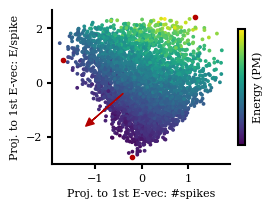

In [42]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.0))
    im = ax.scatter(
        projected_numSpikes[:4000].T,
        projected_e_per_spike_1[:4000].T,
        s=3,
        c=energies_train[:4000],
    )
    ax.scatter(parameter_set1_dim2, parameter_set1_dim1, color="#b30000")
    ax.scatter(parameter_set2_dim2, parameter_set2_dim1, color="#b30000")
    ax.scatter(parameter_set3_dim2, parameter_set3_dim1, color="#b30000")
    ax.annotate(
        "",
        xy=(-1.2, -1.6),
        xytext=(-0.4, -0.4),
        arrowprops=dict(
            facecolor="#b30000",
            edgecolor="#b30000",
            headwidth=5.4,
            headlength=5.7,
            width=0.1,
        ),
    )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel("Proj. to 1st E-vec: #spikes")
    ax.set_ylabel("Proj. to 1st E-vec: E/spike")
    cbar = plt.colorbar(im, aspect=15, fraction=0.04, pad=0.04)
    cbar.set_ticks([])
    cbar.set_label("Energy (PM)", labelpad=5)
    plt.savefig(PANEL_C_NEW, facecolor="None", transparent=True)

In [43]:
angle

1.9026946707586512

### Non-orthogonal version

In [44]:
angle_within_90deg = math.pi - angle

In [45]:
from matplotlib import ticker
my_ticker = ticker.FixedFormatter([-2,0,2])
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

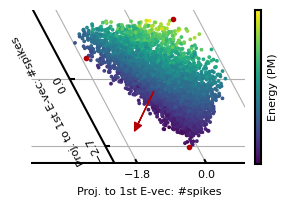

In [226]:
import numpy as np
import matplotlib.pyplot as plt
from  mpl_toolkits.axisartist.grid_helper_curvelinear import GridHelperCurveLinear
from mpl_toolkits.axisartist import Subplot, ParasiteAxesAuxTrans
import  mpl_toolkits.axisartist.angle_helper as angle_helper
from mpl_toolkits.axisartist.grid_finder import FixedLocator

def curvelinear_test1(fig):
    def tr(x, y):
        x, y = np.asarray(x), np.asarray(y)
        return x-y / math.tan(angle_within_90deg), y
    def inv_tr(x,y):
        x, y = np.asarray(x), np.asarray(y)
        return x + y * math.tan(angle_within_90deg), y
    
    grid_locator1 = FixedLocator([-1.8, 0, 1.8])
    grid_locator2 = FixedLocator([-2.7, 0])

    grid_helper = GridHelperCurveLinear(aux_trans=(tr, inv_tr), 
                                        grid_locator1=grid_locator1,
                                        grid_locator2=grid_locator2)
    
    ax1 = Subplot(fig, 1, 1, 1, grid_helper=grid_helper)
    fig.add_subplot(ax1)
    
#     ax1.grid(zorder=-100)
    ax1.grid(True, which='minor', zorder=-100)
    
    projected_data_x, projected_data_y = tr(projected_numSpikes[:4000].T, projected_e_per_spike_1[:4000].T)
    im = ax1.scatter(
        projected_data_x,
        projected_data_y,
        s=3,
        c=energies_train[:4000],
    )
    ax1.scatter(*tr(parameter_set1_dim2, parameter_set1_dim1), color="#b30000")
    ax1.scatter(*tr(parameter_set2_dim2, parameter_set2_dim1), color="#b30000")
    ax1.scatter(*tr(parameter_set3_dim2, parameter_set3_dim1), color="#b30000")
    
    ax1.annotate(
        "",
        xy=(-0.7, -2.1),
        xytext=(-0.2, -0.5),
        arrowprops=dict(
            facecolor="#b30000",
            edgecolor="#b30000",
            headwidth=5.4,
            headlength=5.7,
            width=0.1,
        ),
    )
    
    ax1.axis["right"].set_visible(False)
    ax1.axis["top"].set_visible(False)
    ax1.axis["bottom"].set_visible(False)
    ax1.axis["left"].set_visible(False)

    xx, yy = tr([3, 6], [5.0, 10.])
    ax1.plot(xx, yy)

    ax1.set_xlim(-3.4, 2.2)
    ax1.set_ylim(-3.42, 2.8)
    
    ax1.set_ylabel("Proj. to 1st E-vec: E / spike")
    ax1.set_xlabel("Proj. to 1st E-vec: #spikes")
    
    ax1.axis["y"]=ax1.new_floating_axis(0, -2.4)
    ax1.axis["x"]=ax1.new_floating_axis(1, -3.4)
    ax1.axis["y"].set_axis_direction("top")
    
    cbar = plt.colorbar(im, aspect=25, fraction=0.04, pad=0.04)
    cbar.set_ticks([])
    cbar.set_label("Energy (PM)", labelpad=5)

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig = plt.figure(figsize=(3.0, 2.0))
    curvelinear_test1(fig)
    plt.savefig(PANEL_C_NEW, facecolor="None", transparent=True)
    plt.show()

In [136]:
all_energies_per_spike = sample_stats[:, 18]
all_energies = sample_stats[:, 21]
all_num_spikes = sample_stats[:, 24]

min_energy_per_spike = np.min(all_energies_per_spike)
max_energy_per_spike = np.max(all_energies_per_spike)

min_energy = np.min(all_energies)
max_energy = np.max(all_energies)

min_num_spikes = np.min(all_num_spikes)
max_num_spikes = np.max(all_num_spikes)

In [137]:
unnorm_set_dim_1 = parameter_set1[0] * std_params + mean_params

unnorm_set_dim_2 = parameter_set2[0] * std_params + mean_params

unnorm_set_dim_3 = parameter_set3[0] * std_params + mean_params

simulation_output_1 = simulate_energyscape(unnorm_set_dim_1, seed=0)
simulation_output_2 = simulate_energyscape(unnorm_set_dim_2, seed=0)
simulation_output_3 = simulate_energyscape(unnorm_set_dim_3, seed=0)

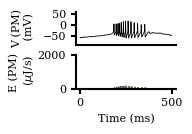

In [151]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    energy_scape(
        simulation_output_1,
        get_time(),
        (1.3, 1.0),
        ["k", "k", "k"],
        time_len=20000,
        offset=116000,
        ylimE=[0, 2000],
        v_labelpad=6.0,
        neuron=0,
    )
    plt.savefig(PANEL_D1_NEW, facecolor="None", transparent=True)

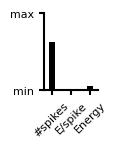

In [152]:
summstats = stats(simulation_output_1)
num_spikes_ABPD = summstats[31]
energies_ABPD_sim = summstats[28]
energyperspike_ABPD_sim = summstats[19]

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(0.7, 1.0))
    height_num_spikes = (num_spikes_ABPD - min_num_spikes) / (
        max_num_spikes - min_num_spikes
    )
    height_energy_per_spike = (energyperspike_ABPD_sim - min_energy_per_spike) / (
        max_energy_per_spike - min_energy_per_spike
    )
    height_energy = (energies_ABPD_sim - min_energy) / (max_energy - min_energy)
    ax.bar(
        np.arange(0, 3),
        [height_num_spikes, height_energy_per_spike, height_energy],
        width=0.3,
        facecolor='k',
    )
    ax.set_ylim([0, 1])
    ax.set_xlim([-0.4, 2.4])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["#spikes", "E/spike", "Energy"], rotation=45)
    ax.set_yticklabels(["min", "max"])
    plt.savefig(PANEL_D2_NEW, facecolor="None", transparent=True)
    plt.show()

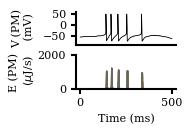

In [153]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    energy_scape(
        simulation_output_2,
        get_time(),
        (1.3, 1.0),
        ["k", "k", "k"],
        time_len=20000,
        offset=292000,
        ylimE=[0, 2000],
        v_labelpad=6.0,
        neuron=0,
    )
    plt.savefig(PANEL_D3_NEW, facecolor="None", transparent=True)

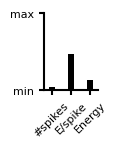

In [154]:
summstats = stats(simulation_output_2)
num_spikes_ABPD = summstats[31]
energies_ABPD_sim = summstats[28]
energyperspike_ABPD_sim = summstats[19]

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(0.7, 1.0))
    height_num_spikes = (num_spikes_ABPD - min_num_spikes) / (
        max_num_spikes - min_num_spikes
    )
    height_energy_per_spike = (energyperspike_ABPD_sim - min_energy_per_spike) / (
        max_energy_per_spike - min_energy_per_spike
    )
    height_energy = (energies_ABPD_sim - min_energy) / (max_energy - min_energy)
    ax.bar(
        np.arange(0, 3),
        [height_num_spikes, height_energy_per_spike, height_energy],
        width=0.3,
        facecolor='k',
    )
    ax.set_ylim([0, 1])
    ax.set_xlim([-0.4, 2.4])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["#spikes", "E/spike", "Energy"], rotation=45)
    ax.set_yticklabels(["min", "max"])
    plt.savefig(PANEL_D4_NEW, facecolor="None", transparent=True)
    plt.show()

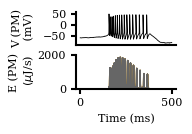

In [155]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    energy_scape(
        simulation_output_3,
        get_time(),
        (1.3, 1.0),
        ["k", "k", "k"],
        time_len=20000,
        offset=210000,
        ylimE=[0, 2000],
        v_labelpad=6.0,
        neuron=0,
    )
    plt.savefig(PANEL_D5_NEW, facecolor="None", transparent=True)

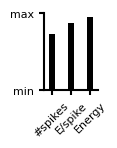

In [156]:
summstats = stats(simulation_output_3)
num_spikes_ABPD = summstats[31]
energies_ABPD_sim = summstats[28]
energyperspike_ABPD_sim = summstats[19]

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(0.7, 1.0))
    height_num_spikes = (num_spikes_ABPD - min_num_spikes) / (
        max_num_spikes - min_num_spikes
    )
    height_energy_per_spike = (energyperspike_ABPD_sim - min_energy_per_spike) / (
        max_energy_per_spike - min_energy_per_spike
    )
    height_energy = (energies_ABPD_sim - min_energy) / (max_energy - min_energy)
    ax.bar(
        np.arange(0, 3),
        [height_num_spikes, height_energy_per_spike, height_energy],
        width=0.3,
        facecolor='k',
    )
    ax.set_ylim([0, 1])
    ax.set_xlim([-0.4, 2.4])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["#spikes", "E/spike", "Energy"], rotation=45)
    ax.set_yticklabels(["min", "max"])
    plt.savefig(PANEL_D6_NEW, facecolor="None", transparent=True)
    plt.show()

# Assemble figure

Todos after the figure:
- #spikes -> E/spike on y-axis
- grid has to be truncated
- "minimal energy" a bit closer together 
- axis truncated

In [187]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [224]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_red = {'size': '7.7pt', 'font': 'Arial', 'color': '#b30000'}

f = Figure("20.3cm", "9.1cm",

    Panel(
         SVG(PANEL_A0_NEW).scale(svg_scale).move(0, 0*factor_svg),
         Text("a", -1.0*factor_svg, 3.2*factor_svg, **kwargs_text),
    ).move(1*factor_svg, -0.7*factor_svg),
    
    Panel(
         SVG(PANEL_A1_NEW).scale(svg_scale).move(0, 0*factor_svg),
        Text("b", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(35*factor_svg, 0.0*factor_svg),
    
    Panel(
         SVG(PANEL_A2_NEW).scale(svg_scale).move(0, 0*factor_svg),
    ).move(57*factor_svg, 0.6*factor_svg),

    Panel(
        SVG(PANEL_B0_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("c", -1.0*factor_svg, 3.2*factor_svg, **kwargs_text),
    ).move(1*factor_svg, 18.3*factor_svg),
    
    Panel(
        SVG(PANEL_B1_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("d", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(35*factor_svg, 19.0*factor_svg),
           
    Panel(
        SVG(PANEL_B2_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(57*factor_svg, 19.6*factor_svg),
    
    Panel(
          SVG(PANEL_C_NEW).scale(svg_scale).move(0*factor_svg,0*factor_svg),
        Text("e", 0.5*factor_svg, 0.5*factor_svg, **kwargs_text),
        Text("g", 12.0*factor_svg, 10.9*factor_svg, **kwargs_text8pt_red),
        Text("h", 27.4*factor_svg, 2.0*factor_svg, **kwargs_text8pt_red),
        Text("f", 30.0*factor_svg, 26.3*factor_svg, **kwargs_text8pt_red),
        Text("minimal", 18.5*factor_svg, 23.6*factor_svg, **kwargs_text8pt_red),
        Text("energy", 18.5*factor_svg, 25.6*factor_svg, **kwargs_text8pt_red),
    ).move(94*factor_svg, 2*factor_svg),
    
    Panel(
          SVG(PANEL_D1_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("f", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(2*factor_svg, 40.0*factor_svg),
    
    Panel(
          SVG(PANEL_D2_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(29*factor_svg, 39.5*factor_svg),
    
    Panel(
          SVG(PANEL_D3_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("g", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(48*factor_svg, 40*factor_svg),
    
    Panel(
          SVG(PANEL_D4_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(75*factor_svg, 39.5*factor_svg),
    
    Panel(
          SVG(PANEL_D5_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("h", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(94*factor_svg, 40*factor_svg),
    
    Panel(
          SVG(PANEL_D6_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(121*factor_svg, 39.5*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig4_new.svg")
svg('../fig/fig4_new.svg')

### Assemble supplementary

In [129]:
f = Figure("20.3cm", "3.9cm",

    Panel(
         SVG(PANEL_supp1).scale(svg_scale).move(0, 0*factor_svg),
         Text("a", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(2*factor_svg, 0.0*factor_svg),
    
    Panel(
        SVG(PANEL_supp2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("b", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(50*factor_svg, 0.0*factor_svg),
    
)

!mkdir -p fig
f.save("../fig/fig4_supp_convergence.svg")
svg('../fig/fig4_supp_convergence.svg')